In [2]:
import copy

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#计算特征值模块
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# 机器学习模块
from sklearn import model_selection
from sklearn.linear_model import Lasso,LassoCV
from sklearn.metrics import mean_squared_error

# 随机森林模块
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#套用网站的九种理化性质计算出来，将序列分成三段，计算相关性，使用lasso进行回归预测，使用随机森林进行预测
#计算靠近的四个端点的理化性质

In [3]:
os.chdir(r'E:\文件\大学课程\大四上\毕业设计\数据分析\ninthweek')
df=pd.read_excel('all-peptides-pairs.xlsx',header=0)
#筛选出第一种分类拿来做实验
testdf=df[(df['stick_terminal']=='c_terminal') & (df['communal-modification']=='AMD') & (df['modification2']=='ACT')]
testdf = testdf[~testdf['sequence'].str.contains('[a-z]')]      #把构象不同的氨基酸筛掉
testdf = testdf[~testdf['sequence'].str.contains('X')]          #把非常规氨基酸筛掉
df_filtered = testdf[testdf['sequence'].str.len() >= 6]          #保证序列长度大于等于4
df_filtered=df_filtered[df_filtered['fold-change']!=0]
# df_filtered.to_excel('df_filtered.xlsx',index=False)

In [4]:
df_filtered

,sequence,target,stick_terminal,communal-modification,measure,unit,modification1,modification2,activity1,activity2,fold-change,abs(none-modification)
4042,ALWKTLLKKVLKA,Staphylococcus aureus B38302,c_terminal,AMD,MIC,uM,none,ACT,9.00,25.00,-1.473931,16.0
4043,ALWKTLLKKVLKA,Escherichia coli U16318,c_terminal,AMD,MIC,uM,none,ACT,4.50,25.00,-2.473931,20.5
4044,RWRWRW,Escherichia coli DSM 30083,c_terminal,AMD,MIC,uM,none,ACT,21.00,45.00,-1.099536,24.0
4045,RWRWRW,Bacillus subtilis DSM 402,c_terminal,AMD,MIC,uM,none,ACT,3.50,45.00,-3.684498,41.5
4046,NPAEDLARYYSALRHYINLITRQRY,Candida albicans ATCC 885-653,c_terminal,AMD,MIC,uM,none,ACT,1.25,3.25,-1.378512,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5768,KWKLFKKIGAVLKVL,Leishmania sp. (amastigote),c_terminal,AMD,LD50,uM,none,ACT,14.40,10.40,0.469485,4.0
5769,KWKLFKKIGAVLKVL,Micrococcus luteus ATCC 15307,c_terminal,AMD,LD50,uM,none,ACT,0.80,0.90,-0.169925,0.1
5770,KWKLFKKIGAVLKVL,Escherichia coli ML-35,c_terminal,AMD,LD50,uM,none,ACT,1.40,0.90,0.637430,0.5
5771,KWKLFKKIGAVLKVL,Acinetobacter baumannii ATCC 19606,c_terminal,AMD,LD50,uM,none,ACT,0.70,0.90,-0.362570,0.2


In [5]:
df_filtered[df_filtered['fold-change']!=0]

,sequence,target,stick_terminal,communal-modification,measure,unit,modification1,modification2,activity1,activity2,fold-change,abs(none-modification)
4042,ALWKTLLKKVLKA,Staphylococcus aureus B38302,c_terminal,AMD,MIC,uM,none,ACT,9.00,25.00,-1.473931,16.0
4043,ALWKTLLKKVLKA,Escherichia coli U16318,c_terminal,AMD,MIC,uM,none,ACT,4.50,25.00,-2.473931,20.5
4044,RWRWRW,Escherichia coli DSM 30083,c_terminal,AMD,MIC,uM,none,ACT,21.00,45.00,-1.099536,24.0
4045,RWRWRW,Bacillus subtilis DSM 402,c_terminal,AMD,MIC,uM,none,ACT,3.50,45.00,-3.684498,41.5
4046,NPAEDLARYYSALRHYINLITRQRY,Candida albicans ATCC 885-653,c_terminal,AMD,MIC,uM,none,ACT,1.25,3.25,-1.378512,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5768,KWKLFKKIGAVLKVL,Leishmania sp. (amastigote),c_terminal,AMD,LD50,uM,none,ACT,14.40,10.40,0.469485,4.0
5769,KWKLFKKIGAVLKVL,Micrococcus luteus ATCC 15307,c_terminal,AMD,LD50,uM,none,ACT,0.80,0.90,-0.169925,0.1
5770,KWKLFKKIGAVLKVL,Escherichia coli ML-35,c_terminal,AMD,LD50,uM,none,ACT,1.40,0.90,0.637430,0.5
5771,KWKLFKKIGAVLKVL,Acinetobacter baumannii ATCC 19606,c_terminal,AMD,LD50,uM,none,ACT,0.70,0.90,-0.362570,0.2


In [ ]:
def Hydrophobicity(seq,index):
    single=['1','2','0','-1','-2','-3']
    if index in single:
        new_index=int(index)
        protein = ProteinAnalysis(seq[new_index])
        gravy_score = protein.gravy()
        return gravy_score
    elif index=='full':
        protein = ProteinAnalysis(seq)
        gravy_score = protein.gravy()
        return gravy_score
    elif index=='start':
        length=len(seq)//3
        seq=seq[:length]
        protein = ProteinAnalysis(seq)
        gravy_score = protein.gravy()
        return gravy_score
    elif index=='end':
        length=len(seq)//3
        seq=seq[-length:]
        protein = ProteinAnalysis(seq)
        gravy_score = protein.gravy()
        return gravy_score
    elif index=='middle':
        length=len(seq)//3
        seq=seq[length:-length]
        protein = ProteinAnalysis(seq)
        gravy_score = protein.gravy()
        return gravy_score
def PI(seq,index):
    single=['1','2','0','-1','-2','-3']
    if index in single:
        new_index=int(index)
        protein = ProteinAnalysis(seq[new_index])
        isoelectric_point = protein.isoelectric_point()
        return isoelectric_point
    elif index=='full':
        protein = ProteinAnalysis(seq)
        isoelectric_point = protein.isoelectric_point()
        return isoelectric_point
    elif index=='start':
        length=len(seq)//3
        seq=seq[:length]
        protein = ProteinAnalysis(seq)
        isoelectric_point = protein.isoelectric_point()
        return isoelectric_point
    elif index=='end':
        length=len(seq)//3
        seq=seq[-length:]
        protein = ProteinAnalysis(seq)
        isoelectric_point = protein.isoelectric_point()
        return isoelectric_point
    elif index=='middle':
        length=len(seq)//3
        seq=seq[length:-length]
        protein = ProteinAnalysis(seq)
        isoelectric_point = protein.isoelectric_point()
        return isoelectric_point
def Charge(seq,index):
    single=['1','2','0','-1','-2','-3']
    if index in single:
        new_index=int(index)
        protein = ProteinAnalysis(seq[new_index])
        charge = protein.charge_at_pH(7)
        return charge
    elif index=='full':
        protein = ProteinAnalysis(seq)
        charge = protein.charge_at_pH(7)
        return charge
    elif index=='start':
        length=len(seq)//3
        seq=seq[:length]
        protein = ProteinAnalysis(seq)
        charge = protein.charge_at_pH(7)
        return charge
    elif index=='end':
        length=len(seq)//3
        seq=seq[-length:]
        protein = ProteinAnalysis(seq)
        charge = protein.charge_at_pH(7)
        return charge
    elif index=='middle':
        length=len(seq)//3
        seq=seq[length:-length]
        protein = ProteinAnalysis(seq)
        charge = protein.charge_at_pH(7)
        return charge

In [7]:
# 计算30个特征
df_attributes=pd.DataFrame()
P_list=['Charge','Hydrophobicity','PI']
types=['0','1','2','-1','-2','-3','full','start','middle','end']
# a_list
for i in types:
    for j in P_list:
        colname='&'.join([i,j])
        if j=='Charge':
            df_attributes[colname]=df_filtered['sequence'].apply(Charge,args=(i,))
        elif j=='Hydrophobicity':
            df_attributes[colname]=df_filtered['sequence'].apply(Hydrophobicity,args=(i,))
        else:
            df_attributes[colname]=df_filtered['sequence'].apply(PI,args=(i,))

In [8]:
#把特征和变量放入一个文件
all_df=copy.deepcopy(df_attributes)
all_df['fold-change']=copy.deepcopy(df_filtered['fold-change'])
all_df

,1&Charge,1&Hydrophobicity,1&PI,2&Charge,2&Hydrophobicity,2&PI,3&Charge,3&Hydrophobicity,3&PI,-1&Charge,...,start&Charge,start&Hydrophobicity,start&PI,middle&Charge,middle&Hydrophobicity,middle&PI,end&Charge,end&Hydrophobicity,end&PI,fold-change
4042,-0.239898,3.8,5.525000,-0.239898,-0.9,5.525000,0.759103,-3.9,8.750052,-0.204125,...,0.794876,0.20,8.795051,1.396199,-0.180000,10.000545,0.732989,1.4750,8.720010,-1.473931
4043,-0.239898,3.8,5.525000,-0.239898,-0.9,5.525000,0.759103,-3.9,8.750052,-0.204125,...,0.794876,0.20,8.795051,1.396199,-0.180000,10.000545,0.732989,1.4750,8.720010,-2.473931
4044,-0.239898,-0.9,5.525000,0.760092,-4.5,9.750021,-0.239898,-0.9,5.525000,-0.239898,...,0.760092,-2.70,9.750021,0.760092,-2.700000,9.750021,0.760092,-2.7000,9.750021,-1.099536
4045,-0.239898,-0.9,5.525000,0.760092,-4.5,9.750021,-0.239898,-0.9,5.525000,-0.239898,...,0.760092,-2.70,9.750021,0.760092,-2.700000,9.750021,0.760092,-2.7000,9.750021,-3.684498
4046,-0.041471,-1.6,5.954987,-0.204125,1.8,5.570017,-1.157935,-3.5,4.599264,-0.240897,...,-1.235977,-1.15,4.370259,0.844269,-0.255556,8.504105,1.759083,-1.2125,10.835024,-1.378512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5768,-0.239898,-0.9,5.525000,0.759103,-3.9,8.750052,-0.239898,3.8,5.525000,-0.239898,...,1.758104,-0.42,10.002737,1.758104,-0.380000,10.002737,0.732989,2.4200,8.720010,0.469485
5769,-0.239898,-0.9,5.525000,0.759103,-3.9,8.750052,-0.239898,3.8,5.525000,-0.239898,...,1.758104,-0.42,10.002737,1.758104,-0.380000,10.002737,0.732989,2.4200,8.720010,-0.169925
5770,-0.239898,-0.9,5.525000,0.759103,-3.9,8.750052,-0.239898,3.8,5.525000,-0.239898,...,1.758104,-0.42,10.002737,1.758104,-0.380000,10.002737,0.732989,2.4200,8.720010,0.637430
5771,-0.239898,-0.9,5.525000,0.759103,-3.9,8.750052,-0.239898,3.8,5.525000,-0.239898,...,1.758104,-0.42,10.002737,1.758104,-0.380000,10.002737,0.732989,2.4200,8.720010,-0.362570


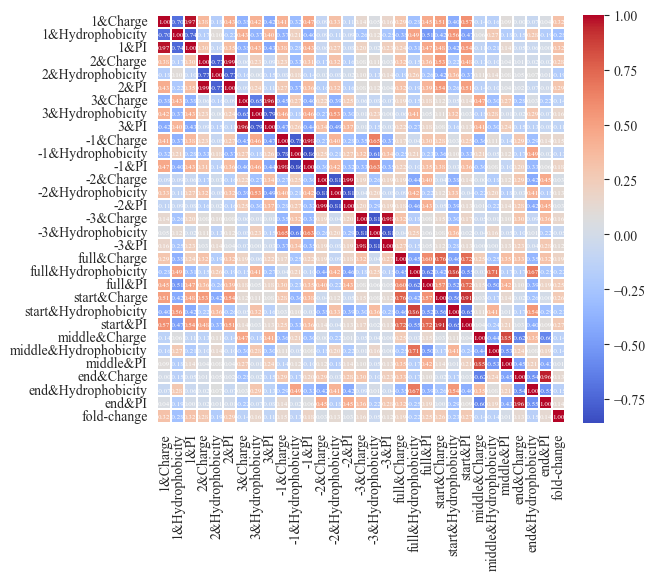

In [9]:
# 计算相关性并绘制相关性热图
corr_data=all_df.corr(method='pearson')
#绘制相关性热图
plt.figure(figsize=(8,6), facecolor='w') # 底色white
cor_map = sns.heatmap(corr_data, square=True, annot=True, fmt='.2f',
                 linewidth=0.1, cmap='coolwarm',linecolor='white', cbar=True,
                 annot_kws={'size':5,'weight':'normal','color':'white'},
                 cbar_kws={'fraction':0.046, 'pad':0.03})
plt.rcParams['font.sans-serif']= ['Times New Roman']    # 设置字体
# plt.xticks(rotation=90,fontsize=8)  # x轴的标签旋转90度
# plt.yticks(fontsize=8)
plt.subplots_adjust(bottom=0.2,left=0.05,right=0.8)
plt.savefig("pdata_corr_heatmap.png", dpi=1300)

In [10]:
plt.savefig("pdata_corr_heatmap.png", dpi=1300)
# 使用lasso直接进行建模
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 读取数据
lasso_model = copy.deepcopy(all_df)  #原始文件改变需要调这里，切记这个原始文件是所有特征和fold-change合在一起了

# 分离特征和因变量
X_lasso = lasso_model.drop('fold-change', axis=1)
y_lasso = lasso_model['fold-change']

# 数据标准化
# scaler = StandardScaler()
# X_lasso = scaler.fit_transform(X_lasso)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_lasso, y_lasso, test_size=0.1, random_state=42)

# Lasso模型训练
lasso = Lasso()
param_grid = {'alpha': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 1, 10]}
grid_search = GridSearchCV(lasso, param_grid=param_grid, cv=10)
grid_search.fit(X_train, y_train)

# 最佳alpha值
best_alpha = grid_search.best_params_['alpha']

# 选择重要特征
lasso = Lasso(alpha=best_alpha)
lasso.fit(X_train, y_train)
coef = pd.Series(lasso.coef_, index=all_df.columns[:-1])  #原始文件改变需要调这里
important_features = coef.abs().nlargest(5).index.tolist()

# 模型评估
y_pred = lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MSE:', mse)
print('R2:', r2)

D:\办公软件\python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.695e+02, tolerance: 5.316e-02
  model = cd_fast.enet_coordinate_descent(
D:\办公软件\python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.775e+02, tolerance: 5.441e-02
  model = cd_fast.enet_coordinate_descent(
D:\办公软件\python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.639e+02, tolerance: 5.205e-02
  model = cd_fast

MSE: 1.801656070266726
R2: -0.15599842144806675


<Figure size 640x480 with 0 Axes>

In [16]:
best_alpha

0.1

In [15]:
# 输出所有特征的系数
sorted_index = coef.abs().argsort()[::-1]
sorted_s = coef.iloc[sorted_index]
sorted_s.to_excel(r'ACT-coef2.xlsx')   #输出具有0的样本

In [12]:
# 根据lasso提取系数较高的特征和变量重建一个文档
newcolumns=['start&Charge','middle&Charge','start&Hydrophobicity','middle&Hydrophobicity','end&Charge','3&PI','full&Hydrophobicity','full&Charge','fold-change']
new_all_data=all_df[newcolumns]
new_all_data

,start&Charge,middle&Charge,start&Hydrophobicity,middle&Hydrophobicity,end&Charge,3&PI,full&Hydrophobicity,full&Charge,fold-change
4042,0.794876,1.396199,0.20,-0.180000,0.732989,8.750052,0.446154,3.791879,-1.473931
4043,0.794876,1.396199,0.20,-0.180000,0.732989,8.750052,0.446154,3.791879,-2.473931
4044,0.760092,0.760092,-2.70,-2.700000,0.760092,5.525000,-2.700000,2.760072,-1.099536
4045,0.760092,0.760092,-2.70,-2.700000,0.760092,5.525000,-2.700000,2.760072,-3.684498
4046,-1.235977,0.844269,-1.15,-0.255556,1.759083,4.599264,-0.848000,1.847171,-1.378512
...,...,...,...,...,...,...,...,...,...
5768,1.758104,1.758104,-0.42,-0.380000,0.732989,5.525000,0.540000,4.755107,0.469485
5769,1.758104,1.758104,-0.42,-0.380000,0.732989,5.525000,0.540000,4.755107,-0.169925
5770,1.758104,1.758104,-0.42,-0.380000,0.732989,5.525000,0.540000,4.755107,0.637430
5771,1.758104,1.758104,-0.42,-0.380000,0.732989,5.525000,0.540000,4.755107,-0.362570


In [13]:
# 随机森林模型
# 将y变为离散型
model_data=copy.deepcopy(all_df)
model_data['sig']=0
model_data.loc[model_data['fold-change']>1,'sig']=1
model_data.loc[model_data['fold-change']<-1,'sig']=-1

# 拆分自变量和变量
X=copy.deepcopy(model_data.drop('fold-change',axis=1))
X=X.drop('sig',axis=1)
y=copy.deepcopy(model_data['sig'])



# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# 构建随机森林模型
rfc = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_leaf=5, random_state=123)

# 在训练集上训练模型
rfc.fit(X_train, y_train)

# 在测试集上测试模型性能
y_pred = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
# 在训练集上训练模型
rfc.fit(X_train, y_train)

# 在测试集上测试模型性能
y_pred = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
# 输出模型评估结果
print("Accuracy:", accuracy)

# 输出评价参数
print(classification_report(y_test, y_pred,target_names=['活性下调','活性不变','活性上调']))
# print(classification_report((y_train,)))

Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

        活性下调       0.50      0.67      0.57         6
        活性不变       0.75      0.80      0.77        15
        活性上调       0.00      0.00      0.00         3

    accuracy                           0.67        24
   macro avg       0.42      0.49      0.45        24
weighted avg       0.59      0.67      0.63        24



D:\办公软件\python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\办公软件\python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\办公软件\python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
# 提取特征重要性
importances = rfc.feature_importances_
indices = importances.argsort()[::-1]
for i in indices:
    print(f"{X.columns[i]}: {importances[i]}")

full&Hydrophobicity: 0.11233436545564562
start&Hydrophobicity: 0.08776673868167109
end&Hydrophobicity: 0.06252638896459625
full&Charge: 0.06012623935924051
end&PI: 0.05404474551991725
full&PI: 0.05308822043328638
end&Charge: 0.052315567105044425
start&PI: 0.04720103040439352
middle&Hydrophobicity: 0.04551012050586707
1&Hydrophobicity: 0.042751462288208864
start&Charge: 0.03702875496079528
middle&Charge: 0.034188114342737774
middle&PI: 0.03287938958356062
3&Hydrophobicity: 0.032653922113319175
2&Hydrophobicity: 0.02790424807254268
-2&Hydrophobicity: 0.02058810095261701
-1&Charge: 0.020040592304888926
1&PI: 0.019456176877643325
-1&Hydrophobicity: 0.019341786566942406
-3&Hydrophobicity: 0.0188793550669951
3&Charge: 0.018692645273429308
1&Charge: 0.014559339804864936
-3&PI: 0.013096055591964008
-3&Charge: 0.01301409288306629
3&PI: 0.01287002529772148
-1&PI: 0.01196535620256805
2&PI: 0.011083458568993055
-2&Charge: 0.010614284491442503
2&Charge: 0.007558965473489515
-2&PI: 0.005920456852547